In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

In [2]:
df_train=pd.read_csv("ravdess_features_train.csv")
df_test=pd.read_csv("ravdess_features_test.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

### Outliers dropping

In [3]:
df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

### Features selection (da implementare)

In [4]:
sel = SelectKBest(k=108)
#X_train = sel.fit_transform(X_train, y_train)
#X_test = sel.transform(X_test)

### Scaling

In [5]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

# Multilayer Perceptron

### Formula empirica 1

$size_{layer}=\sqrt{input*output}$ da cui per 2 layers:

\begin{cases}
    size_1 = \sqrt{input*size_2} \\
    size_2 = \sqrt{size_1*output}
\end{cases}

risolvendo si ha:

\begin{cases}
    size_1 = (input^2*output)^{1/3} \\
    size_2 = (input*output^2)^{1/3}
\end{cases}

Per 2 layers:

In [6]:
layer_size_1 = ((X_train.shape[1]**2)*len(np.unique(y_train)))**(1/3)
layer_size_2 = ((X_train.shape[1])*len(np.unique(y_train))**2)**(1/3)
layer_size_1, layer_size_2

(104.1890054135137, 28.870608641109552)

In [7]:
clf = MLPClassifier(hidden_layer_sizes=(104,29), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5024311183144247
F1-score [0.44736842 0.61244019 0.45833333 0.46808511 0.42718447 0.59701493
 0.36666667 0.60194175]
              precision    recall  f1-score   support

           0       0.61      0.35      0.45        96
           1       0.53      0.72      0.61        89
           2       0.46      0.46      0.46        96
           3       0.48      0.46      0.47        48
           4       0.40      0.46      0.43        48
           5       0.57      0.62      0.60        96
           6       0.39      0.34      0.37        96
           7       0.56      0.65      0.60        48

    accuracy                           0.50       617
   macro avg       0.50      0.51      0.50       617
weighted avg       0.50      0.50      0.50       617



Per un layer

In [8]:
layer_size = np.sqrt(X_train.shape[1]*len(np.unique(y_train)))
layer_size

54.84523680320835

In [9]:
clf = MLPClassifier(hidden_layer_sizes=(55), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.513776337115073
F1-score [0.49367089 0.61691542 0.50246305 0.52941176 0.39583333 0.57281553
 0.38461538 0.53571429]
              precision    recall  f1-score   support

           0       0.63      0.41      0.49        96
           1       0.55      0.70      0.62        89
           2       0.48      0.53      0.50        96
           3       0.50      0.56      0.53        48
           4       0.40      0.40      0.40        48
           5       0.54      0.61      0.57        96
           6       0.50      0.31      0.38        96
           7       0.47      0.62      0.54        48

    accuracy                           0.51       617
   macro avg       0.51      0.52      0.50       617
weighted avg       0.52      0.51      0.51       617



### Formula empirica 2

$size_{layer} = \frac{2}{3}input + output$

In [10]:
layer_size = 2*X_train.shape[1]/3+len(np.unique(y_train))
layer_size

258.66666666666663

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(int(layer_size)), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5251215559157212
F1-score [0.47741935 0.64390244 0.50717703 0.52083333 0.42718447 0.61616162
 0.34615385 0.58928571]
              precision    recall  f1-score   support

           0       0.63      0.39      0.48        96
           1       0.57      0.74      0.64        89
           2       0.47      0.55      0.51        96
           3       0.52      0.52      0.52        48
           4       0.40      0.46      0.43        48
           5       0.60      0.64      0.62        96
           6       0.45      0.28      0.35        96
           7       0.52      0.69      0.59        48

    accuracy                           0.53       617
   macro avg       0.52      0.53      0.52       617
weighted avg       0.53      0.53      0.52       617



### Formula empirica 3

$size_{layer} = \frac{input+output}{2}$ da cui per 2 layers:

\begin{cases}
    size_1 = \frac{input+size_2}{2} \\
    size_2 = \frac{size_1+output}{2}
\end{cases}

risolvendo si ha:

\begin{cases}
    size_1 = \frac{2}{3}input+\frac{1}{3}output \\
    size_2 = \frac{1}{3}input+\frac{2}{3}output
\end{cases}

Per 2 layers:

In [12]:
layer_size_1 = 2*X_train.shape[1]/3+len(np.unique(y_train))/3
layer_size_2 = X_train.shape[1]/3+2*len(np.unique(y_train))/3
layer_size_1, layer_size_2

(253.33333333333331, 130.66666666666666)

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(75,int(layer_size_2)), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5105348460291734
F1-score [0.44720497 0.63111111 0.45744681 0.52083333 0.47272727 0.60204082
 0.32911392 0.58      ]
              precision    recall  f1-score   support

           0       0.55      0.38      0.45        96
           1       0.52      0.80      0.63        89
           2       0.47      0.45      0.46        96
           3       0.52      0.52      0.52        48
           4       0.42      0.54      0.47        48
           5       0.59      0.61      0.60        96
           6       0.42      0.27      0.33        96
           7       0.56      0.60      0.58        48

    accuracy                           0.51       617
   macro avg       0.51      0.52      0.51       617
weighted avg       0.51      0.51      0.50       617



Per 1 layer:

In [14]:
layer_size = (X_train.shape[1]+len(np.unique(y_train)))/2
layer_size

192.0

In [15]:
clf = MLPClassifier(hidden_layer_sizes=(int(layer_size)), random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5072933549432739
F1-score [0.49056604 0.62264151 0.46766169 0.50549451 0.37254902 0.61165049
 0.30872483 0.57894737]
              precision    recall  f1-score   support

           0       0.62      0.41      0.49        96
           1       0.54      0.74      0.62        89
           2       0.45      0.49      0.47        96
           3       0.53      0.48      0.51        48
           4       0.35      0.40      0.37        48
           5       0.57      0.66      0.61        96
           6       0.43      0.24      0.31        96
           7       0.50      0.69      0.58        48

    accuracy                           0.51       617
   macro avg       0.50      0.51      0.49       617
weighted avg       0.51      0.51      0.50       617



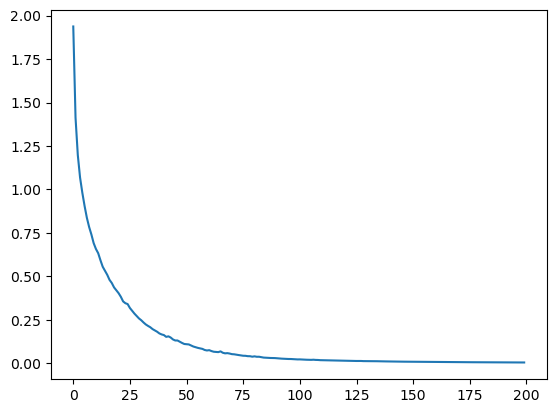

In [16]:
plt.plot(clf.loss_curve_)
plt.show()

### RandomSearchCV

In [17]:
'''
param_grid = {
    "hidden_layer_sizes": [(104,29), (55), (259), (253,131), (192)],
    "activation": ["relu", "tanh", "logistic"],
    "alpha": np.linspace(0.001,0.005,num=10),
    #"momentum": np.linspace(0,1,num=11),
    "learning_rate_init": np.linspace(0.001,0.01,num=11)
}
grid = RandomizedSearchCV(
    MLPClassifier(solver="adam",learning_rate="adaptive"),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_params_


param_grid = {
    "hidden_layer_sizes": [(45,19), (29), (80), (75,41), (58)],
    "activation": ["relu", "tanh", "logistic"],
    "alpha": np.linspace(0.001,0.005,num=10),
    #"momentum": np.linspace(0,1,num=11),
    "learning_rate_init": np.linspace(0.001,0.01,num=11)
}
grid = RandomizedSearchCV(
    MLPClassifier(solver="adam",learning_rate="adaptive"),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_params_
'''

'\nparam_grid = {\n    "hidden_layer_sizes": [(104,29), (55), (259), (253,131), (192)],\n    "activation": ["relu", "tanh", "logistic"],\n    "alpha": np.linspace(0.001,0.005,num=10),\n    #"momentum": np.linspace(0,1,num=11),\n    "learning_rate_init": np.linspace(0.001,0.01,num=11)\n}\ngrid = RandomizedSearchCV(\n    MLPClassifier(solver="adam",learning_rate="adaptive"),\n    param_distributions=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=500,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_params_\n\n\nparam_grid = {\n    "hidden_layer_sizes": [(45,19), (29), (80), (75,41), (58)],\n    "activation": ["relu", "tanh", "logistic"],\n    "alpha": np.linspace(0.001,0.005,num=10),\n    #"momentum": np.linspace(0,1,num=11),\n    "learning_rate_init": np.linspace(0.001,0.01,num=11)\n}\ngrid = RandomizedSearchCV(\n    MLPClassifier(solver="adam",learning_rate="adaptive"),\n    param_distributions=param_grid,\n    scoring="

In [18]:
#grid.best_params_

### Best params for complete dataset(only outliers dropout): {'learning_rate_init': 0.0064,'hidden_layer_sizes': 259,'alpha': 0.003666666666666667,'activation': 'relu'}
### Best params for pruned dataset: {'learning_rate_init': 0.0064,'hidden_layer_sizes': (58),'alpha': 0.003666666666666667,'activation': 'relu'}

In [19]:
clf = MLPClassifier(activation="relu", early_stopping=True, hidden_layer_sizes=(259), solver="adam", alpha=0.003666666666666667, learning_rate="adaptive", learning_rate_init=0.0064, random_state=0, max_iter=1000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.520259319286872
F1-score [0.45962733 0.62559242 0.49751244 0.48888889 0.44660194 0.61928934
 0.37575758 0.58490566]
              precision    recall  f1-score   support

           0       0.57      0.39      0.46        96
           1       0.54      0.74      0.63        89
           2       0.48      0.52      0.50        96
           3       0.52      0.46      0.49        48
           4       0.42      0.48      0.45        48
           5       0.60      0.64      0.62        96
           6       0.45      0.32      0.38        96
           7       0.53      0.65      0.58        48

    accuracy                           0.52       617
   macro avg       0.51      0.52      0.51       617
weighted avg       0.52      0.52      0.51       617



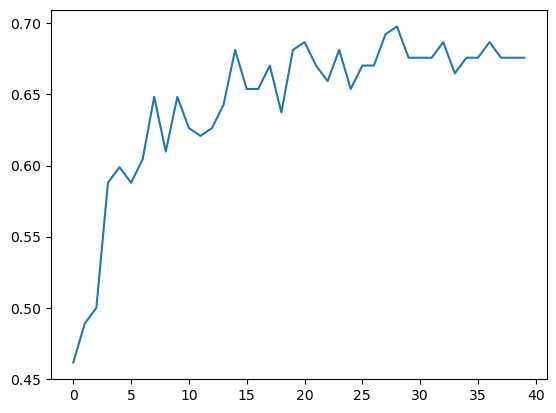

In [20]:
plt.plot(clf.validation_scores_)
plt.show()

### Keras

In [21]:
def build_model():
    
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.05))
    model.add(Dense(259, activation='relu', kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer="adam", weighted_metrics=['accuracy'])
    return model

In [22]:
es = EarlyStopping(monitor='val_accuracy', patience=40, verbose=True)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_accuracy', save_best_only=True)
clf = KerasClassifier(model=build_model, 
                      callbacks=[es],
                      batch_size=128, optimizer="adam", class_weight="balanced")

In [23]:
clf.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
12/12 [==============================] - 1s 39ms/step - loss: 14.5765 - accuracy: 0.3210 - val_loss: 12.8438 - val_accuracy: 0.3825
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 11.4427 - accuracy: 0.5453 - val_loss: 10.2504 - val_accuracy: 0.4619
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 8.9934 - accuracy: 0.6134 - val_loss: 8.1913 - val_accuracy: 0.4435
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 7.0551 - accuracy: 0.6678 - val_loss: 6.6146 - val_accuracy: 0.4336
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 5.5802 - accuracy: 0.7024 - val_loss: 5.3962 - val_accuracy: 0.4405
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 4.4724 - accuracy: 0.7124 - val_loss: 4.4861 - val_accuracy: 0.4697
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 3.6489 - accuracy: 0.7355 - val_loss: 3.8346 - val_accuracy: 0.4784
Epoch 8

KerasClassifier(
	model=<function build_model at 0x0000021640CF5DC0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x0000021642651FD0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=balanced
)

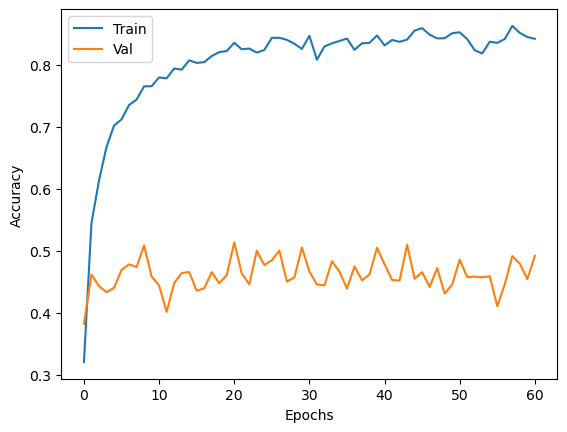

In [24]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

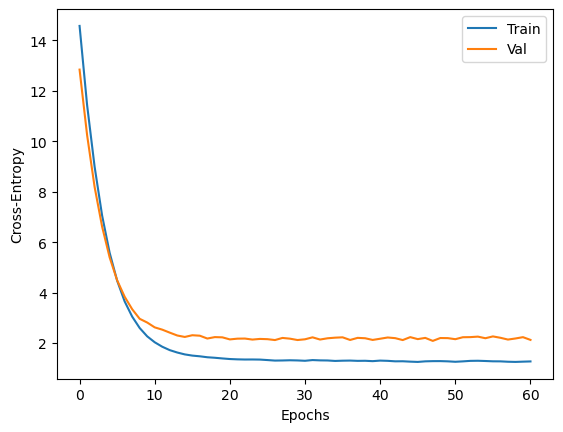

In [25]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [26]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

5/5 [==============================] - 0s 3ms/step
Accuracy 0.5072933549432739
F1-score [0.525      0.61206897 0.37662338 0.53125    0.48648649 0.57458564
 0.38297872 0.48888889]
              precision    recall  f1-score   support

           0       0.66      0.44      0.53        96
           1       0.50      0.80      0.61        89
           2       0.50      0.30      0.38        96
           3       0.42      0.71      0.53        48
           4       0.36      0.75      0.49        48
           5       0.61      0.54      0.57        96
           6       0.60      0.28      0.38        96
           7       0.52      0.46      0.49        48

    accuracy                           0.51       617
   macro avg       0.52      0.53      0.50       617
weighted avg       0.54      0.51      0.49       617



### Parameters to avoid overfitting

In [27]:
def grid_build_model(kernel_reg,dropout):
    
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(kernel_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(259, activation='relu', kernel_regularizer=l2(kernel_reg), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(8, activation='softmax', kernel_regularizer=l2(kernel_reg), kernel_constraint=MaxNorm(3)))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer="adam", weighted_metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy', patience=40, verbose=True)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_accuracy', save_best_only=True)

No parameter to avoid overfitting

In [28]:
clf = KerasClassifier(model=grid_build_model(kernel_reg=0,dropout=0), 
                  callbacks=[es],
                  batch_size=128, optimizer="adam", class_weight="balanced", verbose=1)
clf.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
12/12 [==============================] - 1s 32ms/step - loss: 1.7462 - accuracy: 0.3317 - val_loss: 1.5497 - val_accuracy: 0.3966
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 1.1722 - accuracy: 0.5864 - val_loss: 1.5469 - val_accuracy: 0.4427
Epoch 3/500
12/12 [==============================] - 0s 11ms/step - loss: 0.9189 - accuracy: 0.6640 - val_loss: 1.7017 - val_accuracy: 0.3998
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 0.7320 - accuracy: 0.7605 - val_loss: 1.6649 - val_accuracy: 0.4590
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 0.6000 - accuracy: 0.8143 - val_loss: 1.8838 - val_accuracy: 0.4240
Epoch 6/500
12/12 [==============================] - 0s 11ms/step - loss: 0.4834 - accuracy: 0.8619 - val_loss: 2.0126 - val_accuracy: 0.3977
Epoch 7/500
12/12 [==============================] - 0s 9ms/step - loss: 0.3920 - accuracy: 0.9010 - val_loss: 1.9297 - val_accuracy: 0.4308
Epoch 8

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x00000216427181C0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x000002164273C070>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=balanced
)

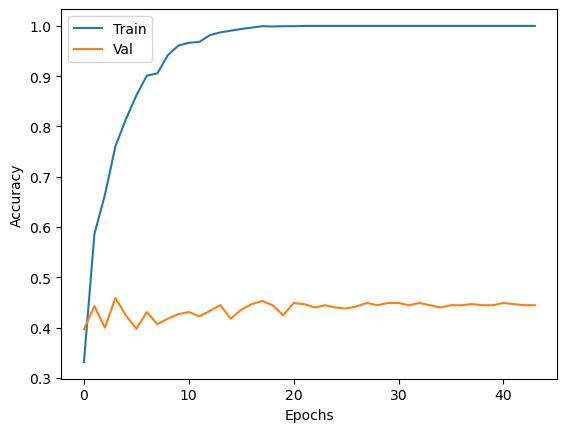

In [29]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

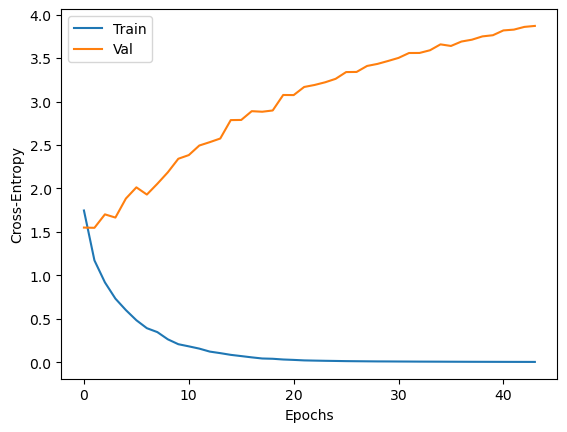

In [30]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

Varying the kernel regularizer

In [31]:
history_reg = []
for k in np.linspace(0,0.1,11):
    clf = KerasClassifier(model=grid_build_model(kernel_reg=k,dropout=0.05), 
                      callbacks=[es],
                      batch_size=128, optimizer="adam", class_weight="balanced", verbose=0)
    clf.fit(X_train, y_train, validation_split=0.2, epochs=500)
    history_reg.append(clf.history_)
    print(k)

Epoch 41: early stopping
0.0
Epoch 126: early stopping
0.01
Epoch 76: early stopping
0.02
Epoch 84: early stopping
0.03
Epoch 117: early stopping
0.04
Epoch 59: early stopping
0.05
Epoch 55: early stopping
0.06
Epoch 44: early stopping
0.07
Epoch 44: early stopping
0.08
Epoch 45: early stopping
0.09
Epoch 44: early stopping
0.1


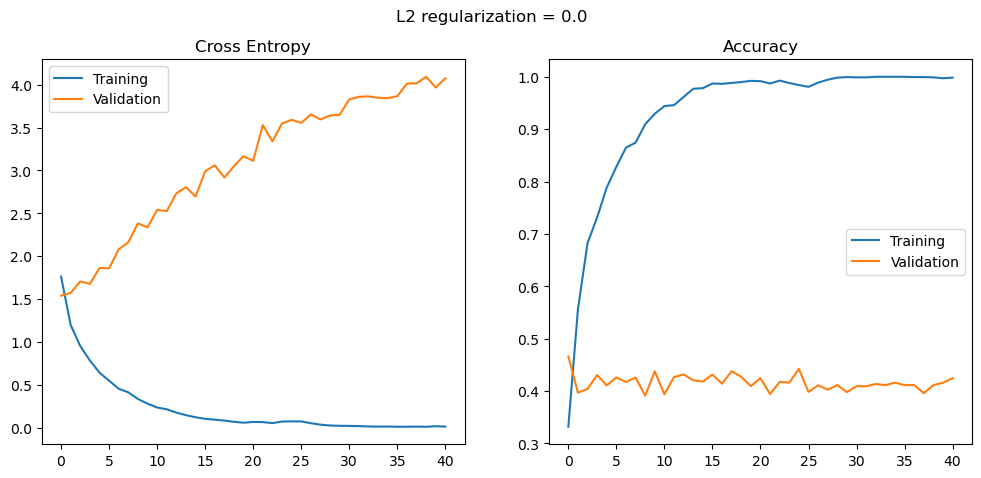

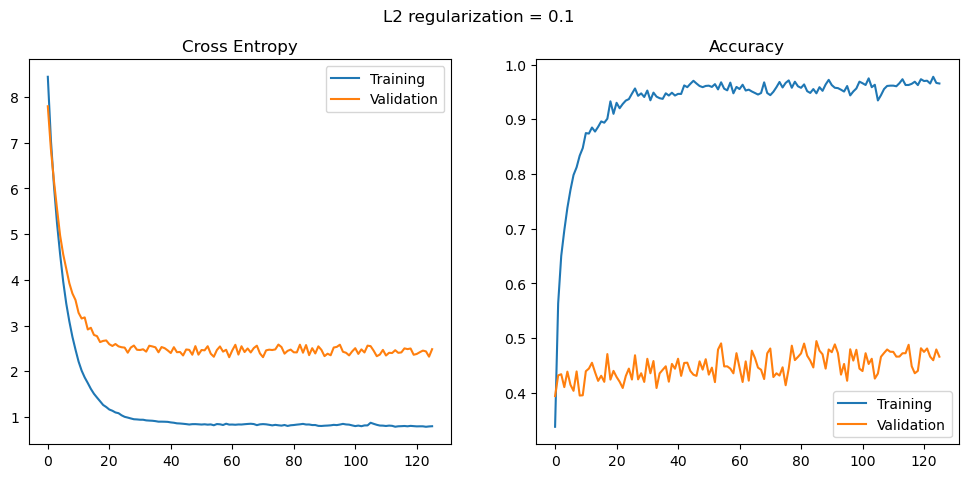

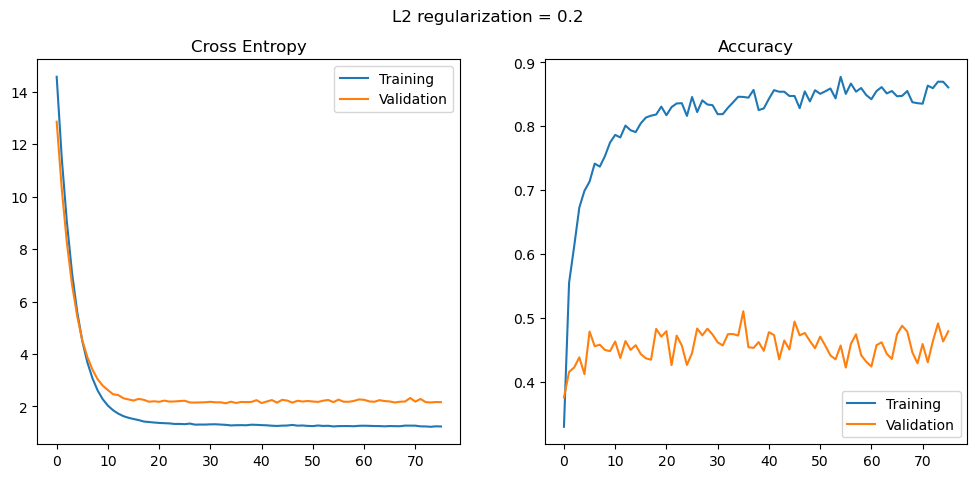

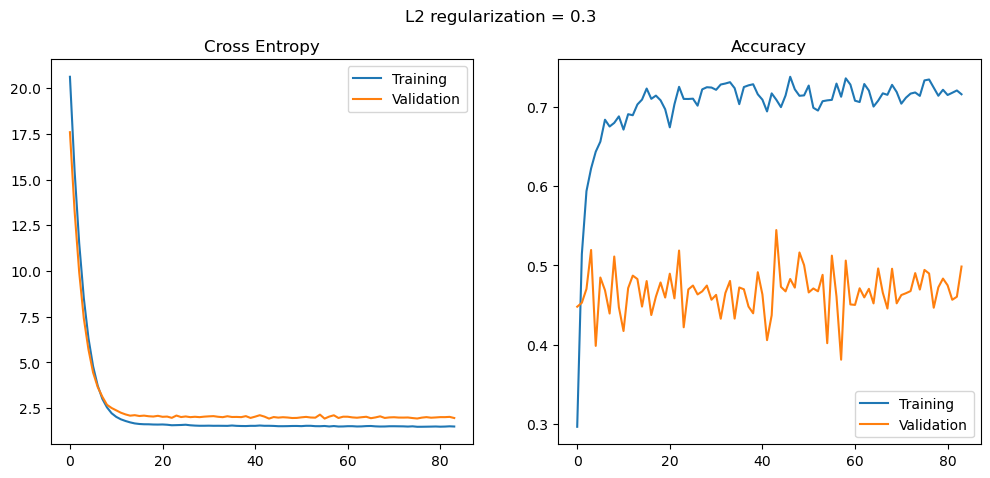

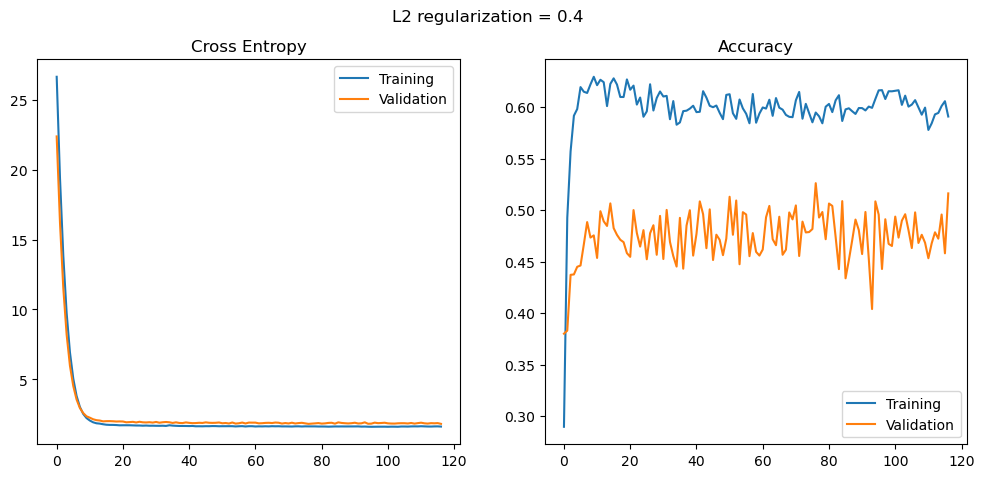

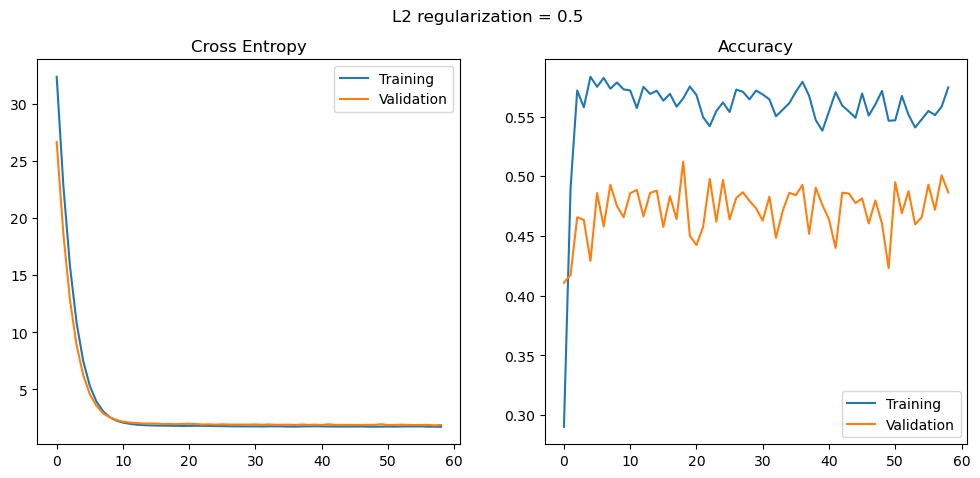

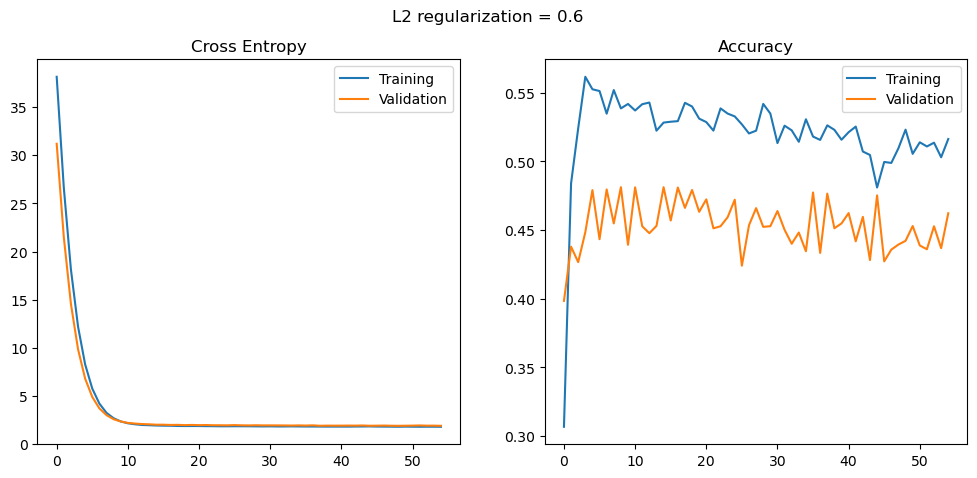

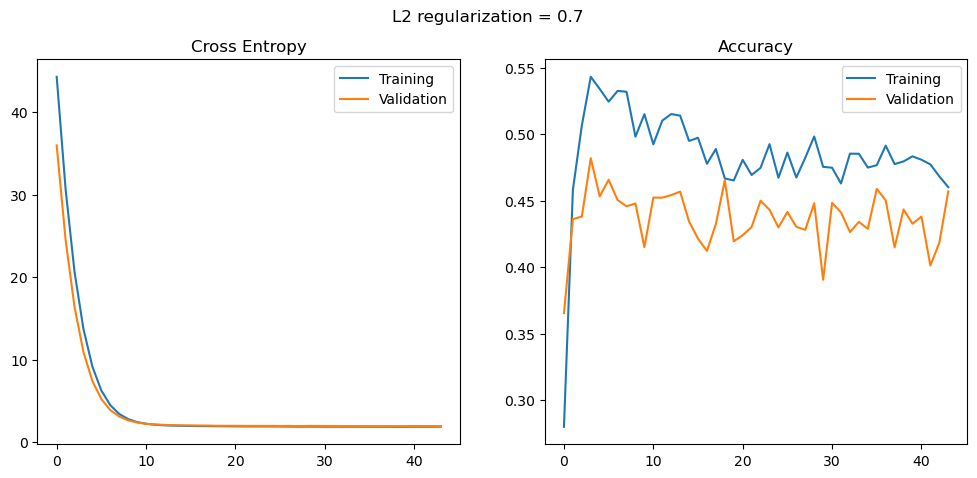

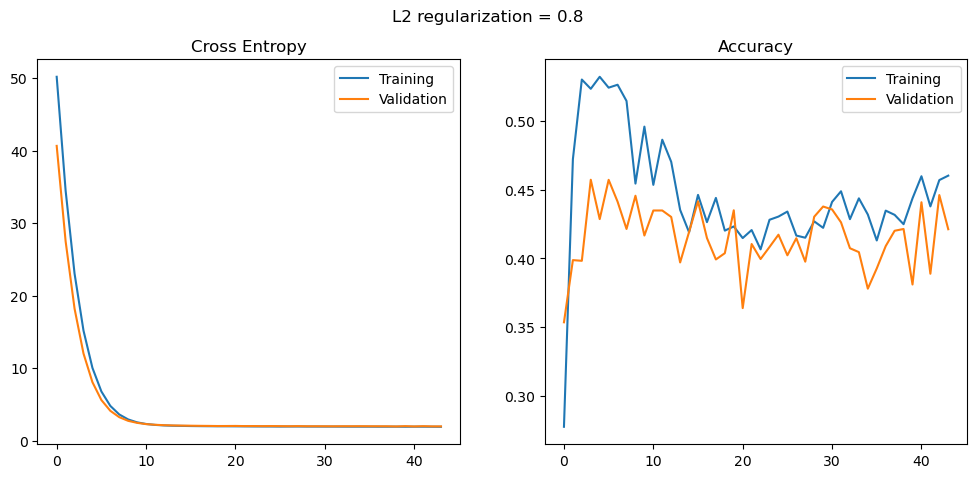

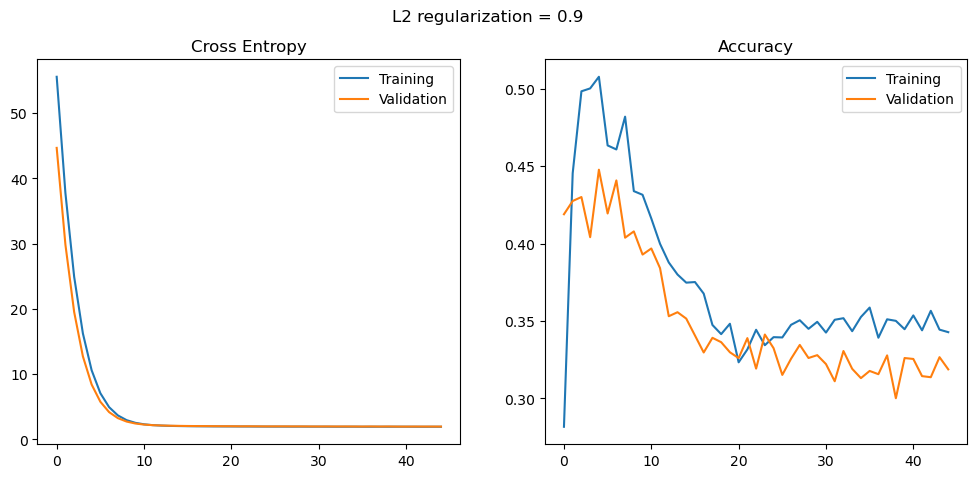

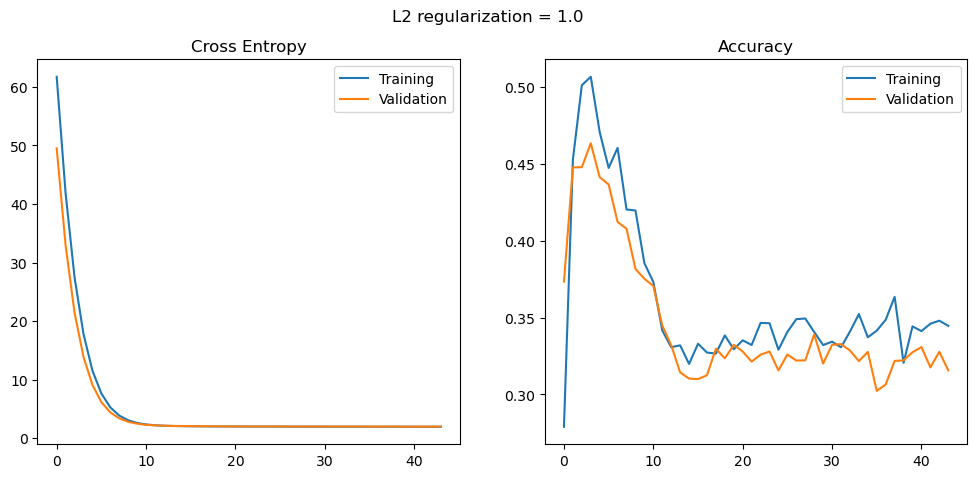

In [32]:
for i in range(len(history_reg)):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(history_reg[i]["loss"], label="Training")
    axs[0].plot(history_reg[i]["val_loss"], label="Validation")
    axs[0].set_title("Cross Entropy")
    axs[0].legend()
    axs[1].plot(history_reg[i]["accuracy"], label="Training")
    axs[1].plot(history_reg[i]["val_accuracy"], label="Validation")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    fig.suptitle("L2 regularization = " + str(i/10))
    plt.show()

Varying the dropout

In [33]:
history_drop = []
for d in np.linspace(0,0.9,10):
    clf = KerasClassifier(model=grid_build_model(kernel_reg=0.02,dropout=d), 
                      callbacks=[es],
                      batch_size=128, optimizer="adam", class_weight="balanced", verbose=0)
    clf.fit(X_train, y_train, validation_split=0.2, epochs=500)
    history_drop.append(clf.history_)
    print(d)

Epoch 131: early stopping
0.0
Epoch 69: early stopping
0.1
Epoch 78: early stopping
0.2
Epoch 96: early stopping
0.30000000000000004
Epoch 62: early stopping
0.4
Epoch 49: early stopping
0.5
Epoch 122: early stopping
0.6000000000000001
Epoch 115: early stopping
0.7000000000000001
Epoch 84: early stopping
0.8
Epoch 195: early stopping
0.9


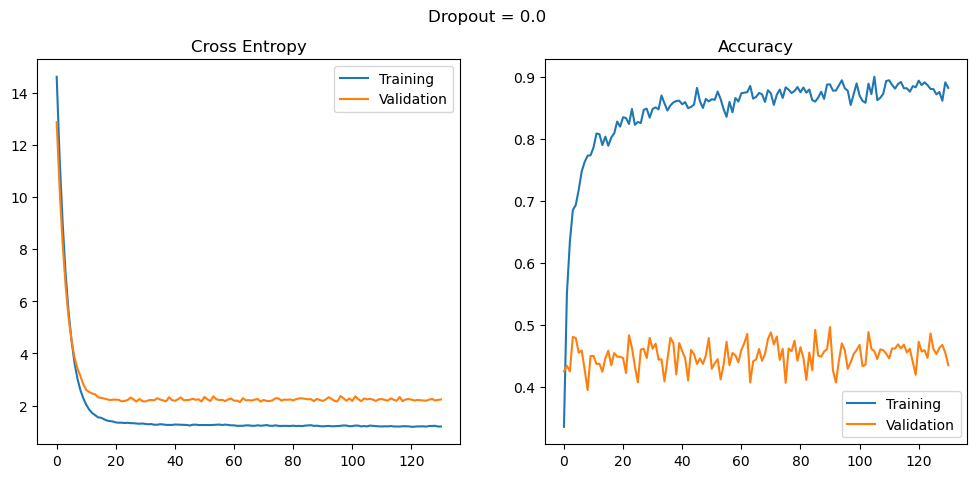

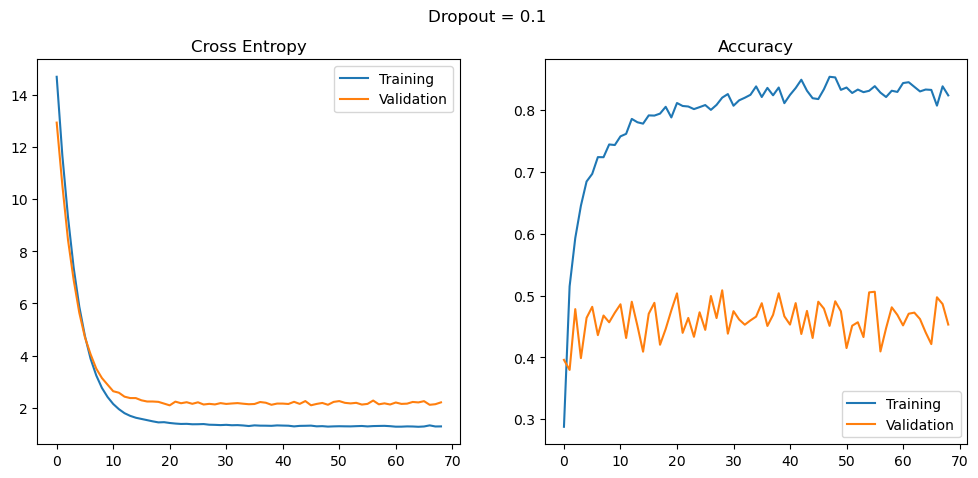

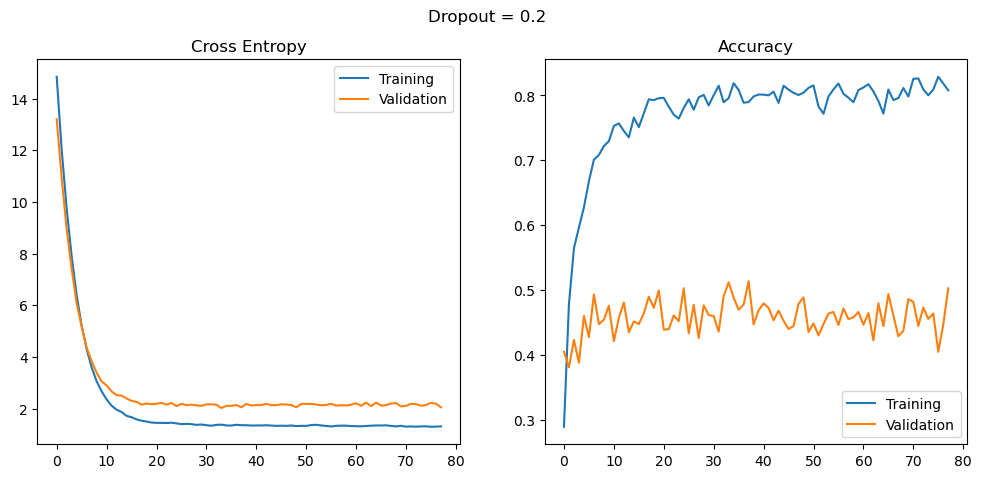

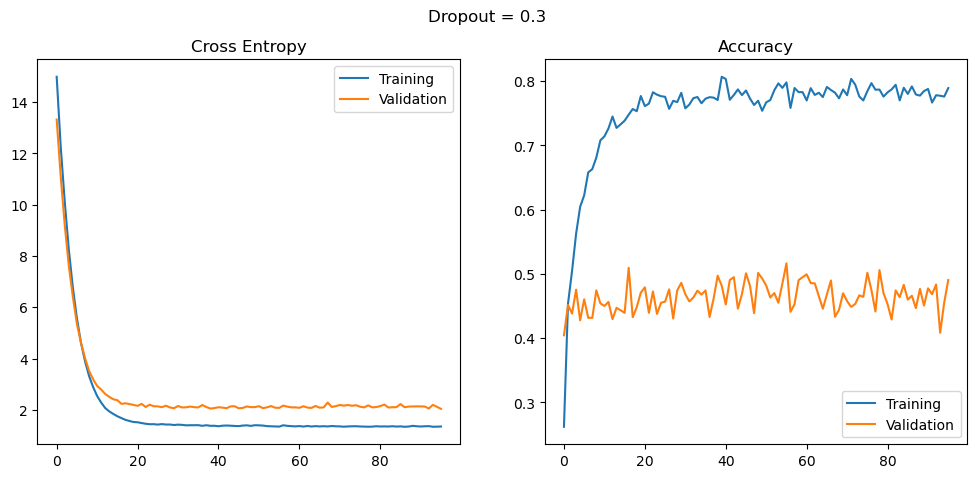

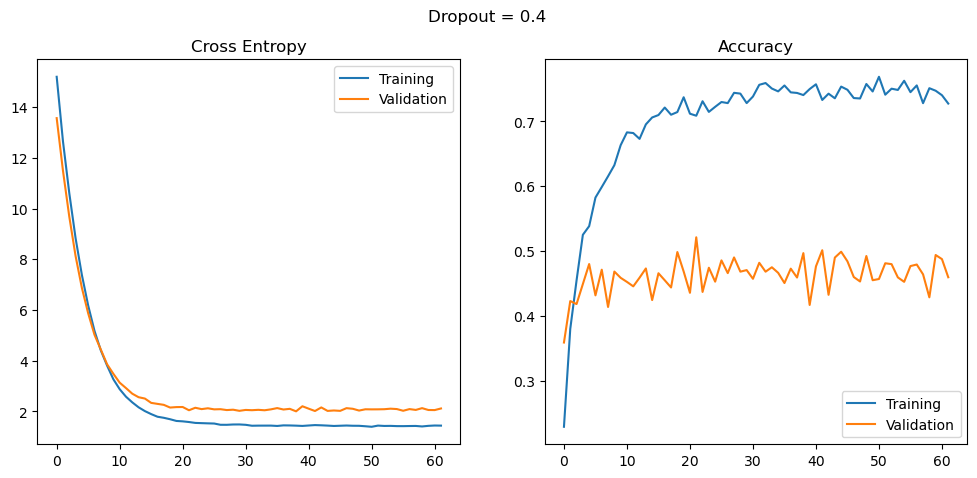

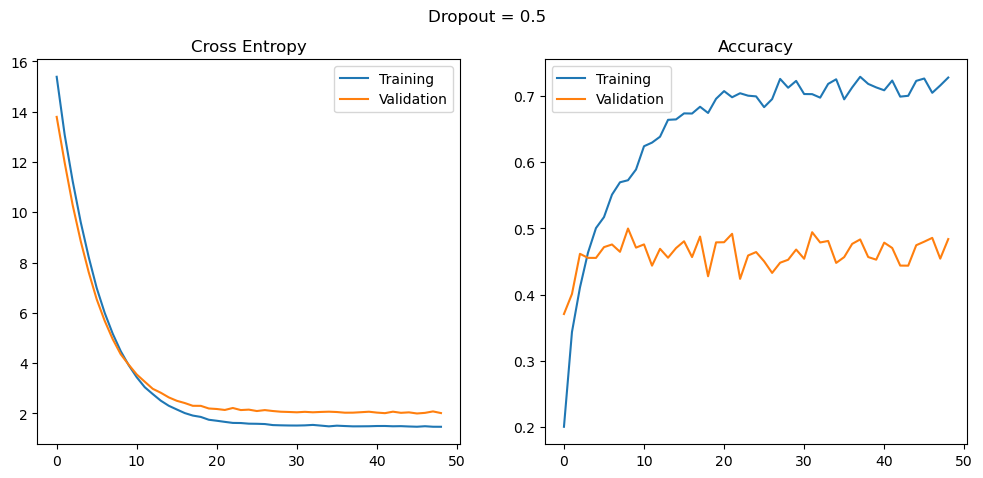

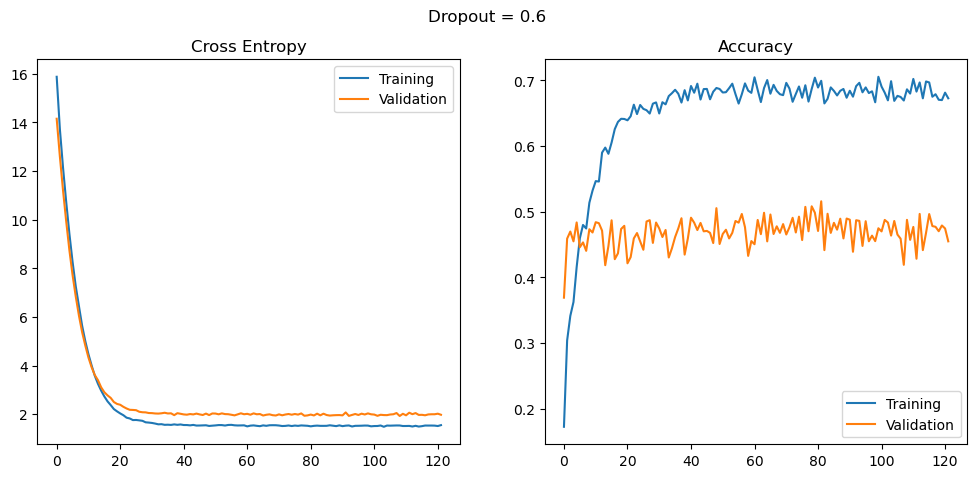

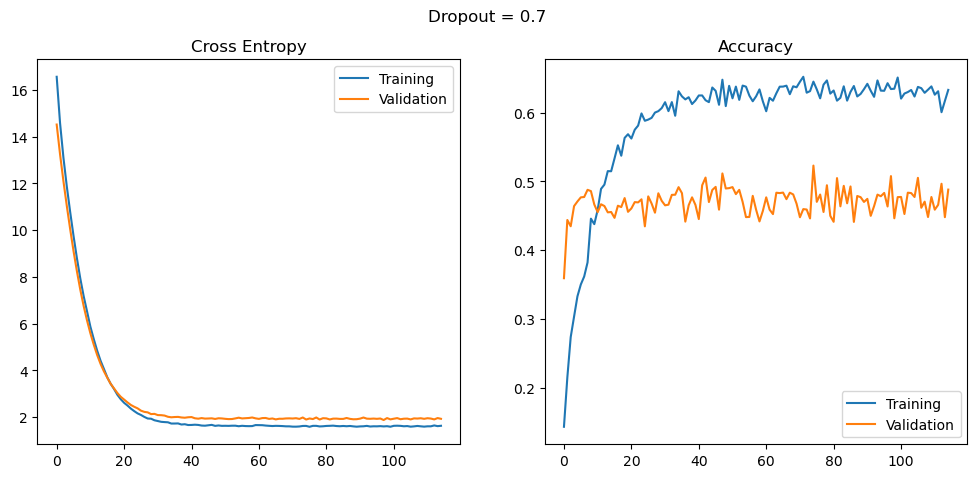

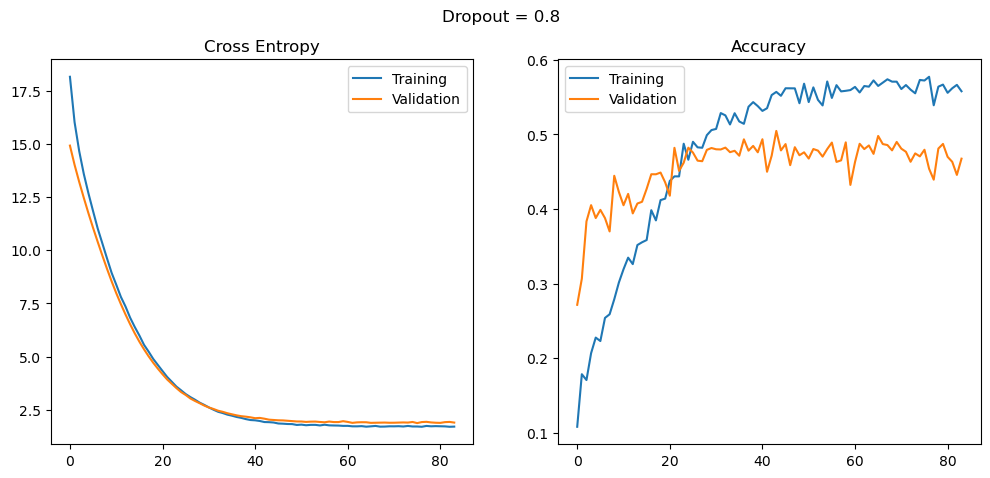

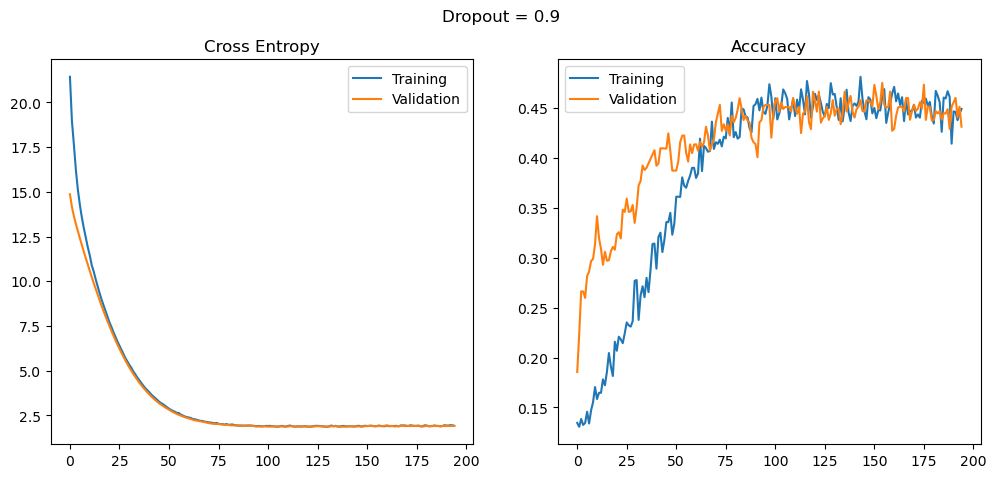

In [34]:
for i in range(len(history_drop)):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(history_drop[i]["loss"], label="Training")
    axs[0].plot(history_drop[i]["val_loss"], label="Validation")
    axs[0].set_title("Cross Entropy")
    axs[0].legend()
    axs[1].plot(history_drop[i]["accuracy"], label="Training")
    axs[1].plot(history_drop[i]["val_accuracy"], label="Validation")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    fig.suptitle("Dropout = " + str(i/10))
    plt.legend()
    plt.show()